## Setup Python and R environment
you can ignore this section

In [3]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [4]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


## Load & Clean Data

👉 Load the data along with the census connectors below (the output of the `connect-to-census.ipynb` notebook) and do any cleanup you'd like to do.

In [4]:
import pandas as pd 

columns = [
    'activity_year', 'county_code', 'lei', 'state_code', 'action_taken',
    'loan_purpose', 'lien_status', 'occupancy_type', 'derived_dwelling_category',
    'applicant_race-1', 'income', 'loan_amount', 'property_value',
    'initially_payable_to_institution','denial_reason-1', 'ffiec_msa_md_median_family_income'
]

df_hmda = pd.read_csv('hmda_all_years.csv')

In [18]:
def clean_county_code(x):
    try:
        return str(int(float(x)))
    except:
        return None

df_hmda['county_code'] = df_hmda['county_code'].apply(clean_county_code)


In [19]:
df_hmda.sort_values(by='loan_amount', ascending=False).head()

,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,income,applicant_race-1,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,ffiec_msa_md_median_family_income
93584888,2020,549300DAUXQ2DCY4H838,MA,25017,Single Family (1-4 Units):Site-Built,4,31,1,5.000006e+11,NaN,...,204.0,6.0,1.0,6.0,NaN,NaN,NaN,NaN,10.0,118800.0
131203215,2022,549300VQUTI5IU7GXT57,GA,13121,Single Family (1-4 Units):Site-Built,5,1,1,2.400003e+11,NaN,...,55.0,3.0,1.0,6.0,NaN,NaN,NaN,NaN,10.0,95700.0
147964425,2023,254900JXCS783CPF1D02,NY,None,Single Family (1-4 Units):Site-Built,3,4,1,2.323232e+11,NaN,...,NaN,7.0,1.0,6.0,NaN,NaN,NaN,NaN,9.0,0.0
89005608,2020,549300ZGTXNHL5BKQZ27,NaN,None,Single Family (1-4 Units):Site-Built,4,1,1,2.000003e+11,NaN,...,180.0,6.0,1.0,6.0,NaN,NaN,NaN,NaN,10.0,0.0
126719826,2022,549300NJVKCDJA5YC939,AZ,4015,Single Family (1-4 Units):Manufactured,4,31,1,4.568360e+10,NaN,...,0.0,6.0,1.0,6.0,NaN,NaN,NaN,NaN,10.0,63100.0


In [21]:
df_hmda.to_csv('hmda_all_years_cleaned.csv', index=False)

## 👉 Grab Census Data

1. loading the Census API key

In [6]:
import dotenv

# Load the environment variables
# (loads CENSUS_API_KEY from .env)
dotenv.load_dotenv()


False

In [7]:
%%R 

require('tidycensus')

# because it an environment variable, we don't have to 
# explicitly pass this string to R, it is readable here
# in this R cell.
census_api_key(Sys.getenv("CENSUS_API_KEY"))

Loading required package: tidycensus
To install your API key for use in future sessions, run this function with `install = TRUE`.


2. Decide which Census variables you want

    Use <https://censusreporter.org/> to figure out which tables you want. (if censusreporter is down, check out the code in the cell below)

    -   Scroll to the bottom of the page to see the tables.
    -   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

    By default this code loads (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

    - find some other variables that you're also interested in
    - don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
    ).


In [24]:
%%R
library(tidycensus)

us_county_data <- get_acs(
  geography = "county",
  variables = c(
    median_household_income = "B19013_001",
    population = "B01003_001",
    white = "B02001_002",
    black = "B02001_003",
    hispanic = "B03003_003",
    GINI_inequality = "B19083_001",
    employment_rate = "B23025_002"

  ),
  year = 2021,
  survey = "acs5",
  geometry = FALSE,
  cache_table = TRUE
)

# Save to CSV so you can use in Python
write.csv(us_county_data, "county_demographics_raw.csv", row.names = FALSE)


Getting data from the 2017-2021 5-year ACS


In [4]:
df_demo = pd.read_csv("county_demographics_raw.csv")

In [26]:
# 1. Pivot the demographics data so each county (GEOID) is a row
df_demo_wide = df_demo.pivot(index="GEOID", columns="variable", values="estimate").reset_index()

# 2. Rename GEOID to match merge key
df_demo_wide = df_demo_wide.rename(columns={"GEOID": "county_code"})

# 3. Make sure both keys are strings and 5-digit padded
df_hmda["county_code"] = df_hmda["county_code"].astype(str).str.zfill(5)
df_demo_wide["county_code"] = df_demo_wide["county_code"].astype(str).str.zfill(5)

# 4. Merge
df_hmda_merged = df_hmda.merge(df_demo_wide, on="county_code", how="left")

# Preview
df_hmda_merged.head()


,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,aus-5,denial_reason-1,ffiec_msa_md_median_family_income,GINI_inequality,black,employment_rate,hispanic,median_household_income,population,white
0,2015,NaN,6,06065,NaN,1,1,1,265.0,NaN,...,NaN,NaN,60500.0,0.4524,156255.0,1131857.0,1211185.0,76066.0,2409331.0,1232550.0
1,2015,NaN,27,27147,NaN,6,3,4,151.0,NaN,...,NaN,NaN,63600.0,0.4266,1247.0,19762.0,3033.0,73468.0,37363.0,33644.0
2,2015,NaN,41,41009,NaN,1,1,1,148.0,NaN,...,NaN,NaN,73900.0,0.4079,264.0,25139.0,3007.0,73909.0,52381.0,46948.0
3,2015,NaN,8,08014,NaN,1,3,1,152.0,NaN,...,NaN,NaN,79900.0,0.4085,1032.0,42638.0,9409.0,107570.0,72697.0,60366.0
4,2015,NaN,6,06039,NaN,6,1,4,161.0,NaN,...,NaN,NaN,45800.0,0.4388,4645.0,65719.0,92400.0,66709.0,156304.0,85946.0


In [20]:
df_hmda_merged = pd.read_csv("merged_hmda_with_demo.csv")

In [7]:
df_hmda_merged.sort_values(by='activity_year', ascending=False).head()


,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,aus-5,denial_reason-1,ffiec_msa_md_median_family_income,GINI_inequality,black,employment_rate,hispanic,median_household_income,population,white
148917887,2023,549300JOT0D4J0SZIK67,FL,12093,Single Family (1-4 Units):Site-Built,6,1,1,85000.0,215000,...,NaN,10.0,65800.0,0.4535,3424.0,15697.0,10470.0,47020.0,39716.0,31392.0
141261959,2023,549300KJKBXR3PD3QQ56,OH,39025,Single Family (1-4 Units):Site-Built,4,1,1,365000.0,NaN,...,NaN,10.0,102300.0,0.4409,2732.0,108519.0,4366.0,73013.0,207650.0,195061.0
141261967,2023,549300KJKBXR3PD3QQ56,OH,39049,Single Family (1-4 Units):Site-Built,1,1,1,225000.0,235000,...,NaN,10.0,100900.0,0.4629,301268.0,725650.0,76968.0,65999.0,1313598.0,833927.0
141261966,2023,549300KJKBXR3PD3QQ56,OH,39057,Single Family (1-4 Units):Site-Built,4,1,1,295000.0,NaN,...,NaN,10.0,92400.0,0.4376,10784.0,85745.0,5109.0,75901.0,167043.0,140513.0
141261965,2023,549300KJKBXR3PD3QQ56,OH,39061,Single Family (1-4 Units):Site-Built,1,1,1,215000.0,225000,...,NaN,10.0,102300.0,0.5016,210408.0,437592.0,29734.0,63080.0,826790.0,547370.0


In [23]:
df_1=df_hmda_merged.head(30)
df_1.to_csv("hmda_merged_with_demo_30.csv", index=False)

In [31]:
#Create a new column for approved loans 
df_hmda_merged['approved'] = df_hmda_merged['action_taken'].apply(lambda x: 1 if x == 1 else 0)


In [32]:
#Create a new column for post-georgefloyd loans
df_hmda_merged['post_georgefloyd'] = df_hmda_merged['activity_year'].apply(lambda x: 1 if x >= 2020 else 0)



Moving into R 

In [8]:
%%R 
# Load libraries
library(tidyverse)
library(broom)

# Load the dataset
df <- read_csv("merged_hmda_with_demo.csv")

# Create binary outcome
df <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code)))
  )


Rows: 148917888 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (23): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In addition: Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `county_code =
  as.character(as.integer(as.numeric(county_code)))`.
Caused by warning:
! NAs introduced by coercion 


In [14]:
%%R
colnames(df)

 [1] "activity_year"                     "lei"                              
 [3] "state_code"                        "county_code"                      
 [5] "derived_dwelling_category"         "action_taken"                     
 [7] "loan_purpose"                      "lien_status"                      
 [9] "loan_amount"                       "property_value"                   
[11] "occupancy_type"                    "income"                           
[13] "applicant_race-1"                  "initially_payable_to_institution" 
[15] "aus-1"                             "aus-2"                            
[17] "aus-3"                             "aus-4"                            
[19] "aus-5"                             "denial_reason-1"                  
[21] "ffiec_msa_md_median_family_income" "GINI_inequality"                  
[23] "black"                             "employment_rate"                  
[25] "hispanic"                          "median_household_income"          

In [15]:
%%R
library(tidyverse)

# Load the dataset
#df <- read_csv("merged_hmda_with_demo.csv")

# Clean and filter
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code)))
  ) %>%
  select(
    activity_year, county_code, lei, state_code, action_taken,
    loan_purpose, lien_status, occupancy_type, derived_dwelling_category,
    `applicant_race-1`, income, loan_amount, property_value,
    initially_payable_to_institution, `denial_reason-1`, ffiec_msa_md_median_family_income, employment_rate, median_household_income, income, post_georgefloyd, approved, population 
  ) %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1
  )


In [16]:
# %%R
# install.packages("fixest")

In [17]:
%%R
df <- df %>%
  mutate(post_georgefloyd = ifelse(activity_year >= 2020, 1, 0))


In [18]:
%%R
df_clean <- df_clean %>%
  mutate(
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0)
  )

In [19]:
%%R
##Use black applicant number and loan level instead of county % 
library(fixest)

fe_model <- feols(
  approved ~ post_georgefloyd * black_applicant + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

summary(fe_model)
#Before 2020, Black applicants were 4.5 percentage points less likely to be approved compared to non-Black applicants, After 2020, the racial approval gap for Black applicants narrowed slightly by 0.6 points

OLS estimation, Dep. Var.: approved
Observations: 38,440,120
Fixed-effects: county_code: 3,220,  activity_year: 6,  lei: 6,078
Standard-errors: Clustered (county_code) 
                                  Estimate  Std. Error    t value  Pr(>|t|)    
black_applicant                  -0.021069    0.002365  -8.910431 < 2.2e-16 ***
employment_rate                   5.188144 6787.668722   0.000764   0.99939    
post_georgefloyd:black_applicant -0.015082    0.001303 -11.573227 < 2.2e-16 ***
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.431704     Adj. R2: 0.224496
                 Within R2: 3.569e-4


NOTE: 1,309,496 observations removed because of NA values (RHS: 1,309,496, Fixed-effects: 1,303,980).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [30]:
%%R
library(dplyr)

# Step 1: Clean the data
df_clean <- df %>%
  mutate(
    approved = ifelse(action_taken == 1, 1, 0),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),
    county_code = as.character(as.integer(as.numeric(county_code))),
    debt_to_income = loan_amount / income,
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0),
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0)
  ) %>%
  select(
    activity_year, county_code, lei, state_code, action_taken,
    loan_purpose, lien_status, occupancy_type, derived_dwelling_category,
    `applicant_race-1`, income, loan_amount, property_value,
    initially_payable_to_institution, `denial_reason-1`,
    ffiec_msa_md_median_family_income, employment_rate,
    median_household_income, income, post_georgefloyd, approved,
    population, debt_to_income, black_applicant, post_dei_law, anti_dei_state
  ) %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    !is.na(debt_to_income), is.finite(debt_to_income)
  )

# Step 2: Run the model
glm_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

# Step 3: View summary
summary(glm_dei)



Error in glm.fit(x = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  : 
  NA/NaN/Inf in 'x'


RInterpreterError: Failed to parse and evaluate line 'library(dplyr)\n\n# Step 1: Clean the data\ndf_clean <- df %>%\n  mutate(\n    approved = ifelse(action_taken == 1, 1, 0),\n    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),\n    county_code = as.character(as.integer(as.numeric(county_code))),\n    debt_to_income = loan_amount / income,\n    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),\n    post_dei_law = ifelse(activity_year >= 2022, 1, 0),\n    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0)\n  ) %>%\n  select(\n    activity_year, county_code, lei, state_code, action_taken,\n    loan_purpose, lien_status, occupancy_type, derived_dwelling_category,\n    `applicant_race-1`, income, loan_amount, property_value,\n    initially_payable_to_institution, `denial_reason-1`,\n    ffiec_msa_md_median_family_income, employment_rate,\n    median_household_income, income, post_georgefloyd, approved,\n    population, debt_to_income, black_applicant, post_dei_law, anti_dei_state\n  ) %>%\n  filter(\n    loan_purpose == 1,\n    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",\n    occupancy_type == 1,\n    !is.na(income), income > 0,\n    !is.na(loan_amount), loan_amount > 0,\n    !is.na(debt_to_income), is.finite(debt_to_income)\n  )\n\n# Step 2: Run the model\nglm_dei <- glm(\n  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,\n  data = df_clean,\n  family = binomial()\n)\n\n# Step 3: View summary\nsummary(glm_dei)\n'.
R error message: "Error in glm.fit(x = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  : \n  NA/NaN/Inf in 'x'"

In [31]:
%%R
library(fixest)
library(dplyr)

# Start from df (raw)
df_clean <- df %>%
  # Create black_applicant dummy
  mutate(
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  # Remove extreme or missing values
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), 
         !is.na(activity_year), !is.na(black_applicant),
         !is.na(income), income > 0,
         !is.na(loan_amount), !is.na(debt_to_income))

# Run model with controls
fe_model_controls <- feols(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income + employment_rate |
    county_code + activity_year + lei,
  data = df_clean
)

# Show results
summary(fe_model_controls)


OLS estimation, Dep. Var.: approved
Observations: 94,327,779
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,225
Standard-errors: Clustered (county_code) 
                                      Estimate   Std. Error    t value
black_applicant                  -7.735822e-02 2.563767e-03 -30.173659
income                           -1.655700e-09 1.313410e-09  -1.260589
loan_amount                       1.080000e-11 8.420000e-12   1.283823
debt_to_income                   -1.574900e-09 1.211520e-09  -1.299975
employment_rate                   4.474529e+01 6.210051e+03   0.007205
post_georgefloyd:black_applicant  2.156609e-03 9.690603e-04   2.225464
                                  Pr(>|t|)    
black_applicant                  < 2.2e-16 ***
income                            0.207549    
loan_amount                       0.199296    
debt_to_income                    0.193703    
employment_rate                   0.994251    
post_georgefloyd:black_applicant  0.026119 *  
... 1

NOTE: 30,997,932 observations removed because of NA values (Fixed-effects: 30,997,932).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [21]:
%%R
dei_states <- c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH")

df_clean <- df_clean %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% dei_states, 1, 0)
  )


In [22]:
%%R
df_clean <- df_clean %>%
  mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))


In [24]:
%%R
df_clean <- df_clean %>%
  mutate(debt_to_income = loan_amount / income)


In [26]:
%%R
library(dplyr)

# Filter out problematic rows
df_dei_clean <- df_clean %>%
  filter(
    !is.na(approved),
    !is.na(post_dei_law),
    !is.na(anti_dei_state),
    !is.na(black_applicant),
    !is.na(income), income > 0,
    !is.na(loan_amount), loan_amount > 0,
    !is.na(debt_to_income),
    is.finite(debt_to_income)
  )

# Run the model
glm_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + black_applicant + income + loan_amount + debt_to_income,
  data = df_dei_clean,
  family = binomial()
)

summary(glm_dei)



Call:
glm(formula = approved ~ post_dei_law * anti_dei_state + black_applicant + 
    income + loan_amount + debt_to_income, family = binomial(), 
    data = df_dei_clean)

Coefficients:
                              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                  7.721e-01  7.799e-04  989.986   <2e-16 ***
post_dei_law                -5.419e-02  8.797e-04  -61.604   <2e-16 ***
anti_dei_state               6.719e-02  1.090e-03   61.668   <2e-16 ***
black_applicant             -2.529e-01  1.234e-03 -204.922   <2e-16 ***
income                      -6.200e-05  4.032e-07 -153.749   <2e-16 ***
loan_amount                  3.976e-08  1.323e-09   30.043   <2e-16 ***
debt_to_income              -3.312e-05  1.607e-07 -206.122   <2e-16 ***
post_dei_law:anti_dei_state  1.847e-02  2.000e-03    9.233   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44792594  on 347681

In addition: Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 


In [27]:
%%R
library(dplyr)

# Step 1: Filter to Black applicants only
df_black <- df_dei_clean %>%
  filter(black_applicant == 1)

# Step 2: Run logistic regression (DEI impact among Black applicants)
glm_black_dei <- glm(
  approved ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income,
  data = df_black,
  family = binomial()
)

# Step 3: Show results
summary(glm_black_dei)



Call:
glm(formula = approved ~ post_dei_law * anti_dei_state + income + 
    loan_amount + debt_to_income, family = binomial(), data = df_black)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  4.517e-01  2.746e-03 164.491  < 2e-16 ***
post_dei_law                -9.543e-02  2.797e-03 -34.119  < 2e-16 ***
anti_dei_state               1.033e-01  3.828e-03  26.979  < 2e-16 ***
income                      -8.938e-05  2.667e-06 -33.511  < 2e-16 ***
loan_amount                  5.079e-07  7.216e-09  70.390  < 2e-16 ***
debt_to_income              -4.680e-05  5.544e-07 -84.404  < 2e-16 ***
post_dei_law:anti_dei_state -3.379e-02  6.711e-03  -5.035 4.77e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4102737  on 3046349  degrees of freedom
Residual deviance: 4077440  on 3046343  degrees of freedom
AIC: 4077454

Number of Fis

In addition: Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 


In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


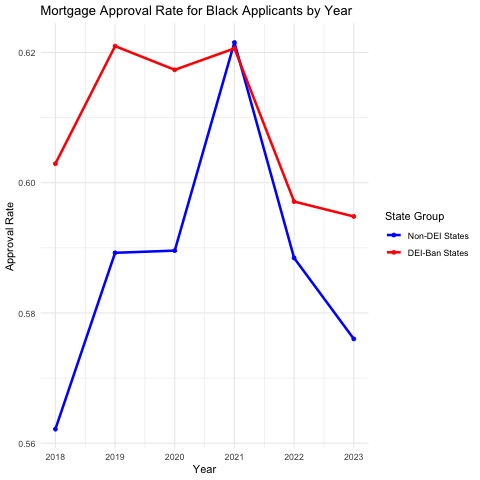

In [28]:
%%R
library(dplyr)
library(ggplot2)

# Step 1: Filter and prepare dataset
df_black <- df_clean %>%
  filter(black_applicant == 1) %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% c("ND", "OK", "TN", "IA", "ID", "FL", "MO", "MT", "NH", "OH"), 1, 0),
    post_dei_law = ifelse(activity_year >= 2022, 1, 0)
  ) %>%
  filter(!is.na(approved))

# Step 2: Calculate approval rate by year and DEI group
approval_by_year_dei <- df_black %>%
  group_by(activity_year, anti_dei_state) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop")

# Step 3: Plot
ggplot(approval_by_year_dei, aes(x = activity_year, y = approval_rate, color = factor(anti_dei_state))) +
  geom_line(size = 1.2) +
  geom_point() +
  scale_color_manual(
    values = c("0" = "blue", "1" = "red"),
    labels = c("Non-DEI States", "DEI-Ban States")
  ) +
  labs(
    title = "Mortgage Approval Rate for Black Applicants by Year",
    x = "Year",
    y = "Approval Rate",
    color = "State Group"
  ) +
  theme_minimal()


In [29]:
%%R

model_black <- feglm(
  approved ~ post_dei_law * anti_dei_state + income + loan_amount + debt_to_income | lei,
  data = df_black,
  family = binomial()
)


NOTES: 50,950 observations removed because of NA and infinite values (RHS: 50,950).
       1,058 fixed-effects (7,551 observations) removed because of only 0 (or only 1) outcomes.
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 3,789,657.2. 


In [ ]:
%%R
# Calculate mean values for continuous variables
mean_income <- mean(df_black$income, na.rm = TRUE)
mean_loan_amount <- mean(df_black$loan_amount, na.rm = TRUE)
mean_dti <- mean(df_black$debt_to_income, na.rm = TRUE)

# Create new data frame for predictions
newdata <- expand.grid(
  post_dei_law = c(0, 1),
  anti_dei_state = c(0, 1)
) %>%
  mutate(
    income = mean_income,
    loan_amount = mean_loan_amount,
    debt_to_income = mean_dti
  )


In [ ]:
%%R
library(fixest)
library(dplyr)

# Start from df (raw)
df_clean <- df %>%
  # Create black_applicant dummy
  mutate(
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    debt_to_income = loan_amount / income
  ) %>%
  # Remove extreme or missing values
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), 
         !is.na(activity_year), !is.na(black_applicant),
         !is.na(income), income > 0,
         !is.na(loan_amount), !is.na(debt_to_income))

# Run model with controls
glm_model <- glm(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial()
)

# Show results
summary(glm_model)


In [13]:
%%R
# Load fixest package
library(fixest)

# Calculate race percentages
df <- df %>%
  mutate(
    pct_black = black / population,
    pct_white = white / population,
    pct_hispanic = hispanic / population
  )

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * pct_black + median_household_income + employment_rate | county_code + activity_year,
  data = df_clean
)

# View results
summary(fe_model)


OLS estimation, Dep. Var.: approved
Observations: 146,258,588
Fixed-effects: county_code: 3,219,  activity_year: 9
Standard-errors: Clustered (county_code) 
                              Estimate Std. Error     t value   Pr(>|t|)    
employment_rate            -0.00000126   0.134997 -0.00000934 9.9999e-01    
post_georgefloyd:pct_black -0.02176838   0.005429 -4.00956038 6.2213e-05 ***
... 2 variables were removed because of collinearity (post_georgefloyd and pct_black)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.484797     Adj. R2: 0.044563
                 Within R2: 7.059e-6


The variables 'post_georgefloyd' and 'pct_black' have been removed because of collinearity (see $collin.var).


In [15]:
%%R
df_clean <- df_clean %>%
  mutate(lei = as.factor(lei))


In [16]:
%%R
# Load fixest package
library(fixest)

# Calculate race percentages
df <- df %>%
  mutate(
    pct_black = black / population,
    pct_white = white / population,
    pct_hispanic = hispanic / population
  )

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(pct_black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * pct_black + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

# View results
summary(fe_model)
#Some banks may be driving racial disparities more than others — when you control for who’s doing the lending, the gap shrinks.


OLS estimation, Dep. Var.: approved
Observations: 110,150,079
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,354
Standard-errors: Clustered (county_code) 
                              Estimate  Std. Error  t value Pr(>|t|) 
pct_black                  4149.439282 48573.29605 0.085426  0.93193 
employment_rate            6154.924223 71807.58989 0.085714  0.93170 
post_georgefloyd:pct_black    0.004392     0.00443 0.991613  0.32146 
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.453057     Adj. R2: 0.170337
                 Within R2: 2.734e-7


NOTE: 36,108,509 observations removed because of NA values (Fixed-effects: 36,108,509).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [18]:
%%R
# Load fixest package
library(fixest)

# Filter out rows with missing values in key variables
df_clean <- df %>%
  filter(!is.na(approved), !is.na(post_georgefloyd), 
         !is.na(black), !is.na(median_household_income), 
         !is.na(employment_rate), !is.na(county_code), !is.na(activity_year))

# Run fixed effects regression using feols (linear probability model)
fe_model <- feols(
  approved ~ post_georgefloyd * black + employment_rate | county_code + activity_year + lei,
  data = df_clean
)

# View results
summary(fe_model)


OLS estimation, Dep. Var.: approved
Observations: 110,150,079
Fixed-effects: county_code: 3,219,  activity_year: 6,  lei: 6,354
Standard-errors: Clustered (county_code) 
                            Estimate   Std. Error   t value Pr(>|t|) 
black                  -1.256893e+04 8.899507e+04 -0.141232  0.88770 
employment_rate         1.206731e+04 8.525426e+04  0.141545  0.88745 
post_georgefloyd:black -5.880000e-09 3.620000e-09 -1.624783  0.10431 
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.453057     Adj. R2: 0.170339
                 Within R2: 1.762e-6


NOTE: 36,108,509 observations removed because of NA values (Fixed-effects: 36,108,509).
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [17]:
%%R
library(ggplot2)

# Sample from your cleaned data for plotting (to keep it fast)
plot_data <- df_clean %>%
  filter(!is.na(pct_black), !is.na(post_georgefloyd), !is.na(approved)) %>%
  select(pct_black, post_georgefloyd, employment_rate) %>%
  sample_n(100000)

# Generate predictions from the model
plot_data$predicted <- predict(fe_model, newdata = plot_data)

# Plot: Approval vs. pct_black by pre/post George Floyd
ggplot(plot_data, aes(x = pct_black, y = predicted, color = factor(post_georgefloyd))) +
  geom_smooth(method = "loess", se = FALSE) +
  labs(
    title = "Predicted Approval Rate vs. % Black Residents",
    x = "Share of Black Population (pct_black)",
    y = "Predicted Approval Rate",
    color = "Post George Floyd (1 = 2020+)"
  ) +
  scale_color_manual(labels = c("Pre-2020", "Post-2020"), values = c("blue", "red")) +
  theme_minimal()


Error in predict.fixest(fe_model, newdata = plot_data) : 
  The variable county_code is absent from the 'newdata' but is needed for prediction (it is a fixed-effect variable).


RInterpreterError: Failed to parse and evaluate line 'library(ggplot2)\n\n# Sample from your cleaned data for plotting (to keep it fast)\nplot_data <- df_clean %>%\n  filter(!is.na(pct_black), !is.na(post_georgefloyd), !is.na(approved)) %>%\n  select(pct_black, post_georgefloyd, employment_rate) %>%\n  sample_n(100000)\n\n# Generate predictions from the model\nplot_data$predicted <- predict(fe_model, newdata = plot_data)\n\n# Plot: Approval vs. pct_black by pre/post George Floyd\nggplot(plot_data, aes(x = pct_black, y = predicted, color = factor(post_georgefloyd))) +\n  geom_smooth(method = "loess", se = FALSE) +\n  labs(\n    title = "Predicted Approval Rate vs. % Black Residents",\n    x = "Share of Black Population (pct_black)",\n    y = "Predicted Approval Rate",\n    color = "Post George Floyd (1 = 2020+)"\n  ) +\n  scale_color_manual(labels = c("Pre-2020", "Post-2020"), values = c("blue", "red")) +\n  theme_minimal()\n'.
R error message: "Error in predict.fixest(fe_model, newdata = plot_data) : \n  The variable county_code is absent from the 'newdata' but is needed for prediction (it is a fixed-effect variable)."

In [13]:
%%R
colnames(df)


 [1] "activity_year"                     "lei"                              
 [3] "state_code"                        "county_code"                      
 [5] "derived_dwelling_category"         "action_taken"                     
 [7] "loan_purpose"                      "lien_status"                      
 [9] "loan_amount"                       "property_value"                   
[11] "occupancy_type"                    "income"                           
[13] "applicant_race-1"                  "initially_payable_to_institution" 
[15] "aus-1"                             "aus-2"                            
[17] "aus-3"                             "aus-4"                            
[19] "aus-5"                             "denial_reason-1"                  
[21] "ffiec_msa_md_median_family_income" "GINI_inequality"                  
[23] "black"                             "employment_rate"                  
[25] "hispanic"                          "median_household_income"          

In [12]:
%%R
library(tidyr)

county_demo_wide <- us_county_data %>%
  select(GEOID, NAME, variable, estimate) %>%
  pivot_wider(names_from = variable, values_from = estimate)

# Save the cleaned wide-format CSV
write.csv(county_demo_wide, "county_demographics.csv", row.names = FALSE)


In [14]:
df_hmda_merged_2 = df_hmda_merged [
    (df_hmda_merged ['loan_purpose'] == 1) &
    (df_hmda_merged ['occupancy_type'] == 1) &
    (df_hmda_merged ['lien_status'] == 1) &
    (df_hmda_merged ['derived_dwelling_category'].isin([
        'Single Family (1-4 Units):Site-Built',
        'Single Family (1-4 Units):Manufactured'
    ]))
]


In [14]:
df_hmda_merged.sort_values(by='loan_amount', ascending=False).head()


,activity_year,lei,state_code,county_code,derived_dwelling_category,action_taken,loan_purpose,lien_status,loan_amount,property_value,...,aus-5,denial_reason-1,ffiec_msa_md_median_family_income,GINI_inequality,black,employment_rate,hispanic,median_household_income,population,white
93584888,2020,549300DAUXQ2DCY4H838,MA,25017.0,Single Family (1-4 Units):Site-Built,4,31,1,5.000006e+11,NaN,...,NaN,10.0,118800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131203215,2022,549300VQUTI5IU7GXT57,GA,13121.0,Single Family (1-4 Units):Site-Built,5,1,1,2.400003e+11,NaN,...,NaN,10.0,95700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147964425,2023,254900JXCS783CPF1D02,NY,00nan,Single Family (1-4 Units):Site-Built,3,4,1,2.323232e+11,NaN,...,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89005608,2020,549300ZGTXNHL5BKQZ27,NaN,00nan,Single Family (1-4 Units):Site-Built,4,1,1,2.000003e+11,NaN,...,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126719826,2022,549300NJVKCDJA5YC939,AZ,4015.0,Single Family (1-4 Units):Manufactured,4,31,1,4.568360e+10,NaN,...,NaN,10.0,63100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
